CODIGO DE ENTRENAMIENTO

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
import json

# CARGAR DATASETS
df_games = pd.read_csv("./data/mlb_games_2024_full.csv")
df_pitchers = pd.read_csv("./data/mlb_pitchers_2024.csv")

# CREAR TARGET
df_target = df_games.groupby("game_id")[["inning_1_home", "inning_1_away"]].sum().reset_index()
df_target["target"] = (df_target["inning_1_home"] + df_target["inning_1_away"] > 0).astype(int)

# INFO BASE DEL JUEGO
df_info = df_games.drop_duplicates("game_id")[["game_id", "home_team", "away_team", "stadium", "day_or_night", "home_plate_umpire"]]
df = df_info.merge(df_target, on="game_id")

# FORMATO FECHA CORRECTO
df_games['date'] = pd.to_datetime(df_games['date'], errors='coerce', dayfirst=True)
df_pitchers['date'] = pd.to_datetime(df_pitchers['date'], errors='coerce', dayfirst=True)

# FRECUENCIA DE UMPIRE Y ESTADIO
umpire_freq = df[["home_plate_umpire", "target"]].dropna().groupby("home_plate_umpire").agg(games=("target", "count"), runs=("target", "sum")).reset_index()
umpire_freq["home_plate_umpire_inning1_freq"] = umpire_freq["runs"] / umpire_freq["games"]
umpire_freq_dict = umpire_freq.set_index("home_plate_umpire")["home_plate_umpire_inning1_freq"].to_dict()
df["home_plate_umpire_inning1_freq"] = df["home_plate_umpire"].map(umpire_freq_dict)

stadium_freq = df[["stadium", "target"]].dropna().groupby("stadium").agg(games=("target", "count"), runs=("target", "sum")).reset_index()
stadium_freq["stadium_inning1_freq"] = stadium_freq["runs"] / stadium_freq["games"]
stadium_freq_dict = stadium_freq.set_index("stadium")["stadium_inning1_freq"].to_dict()
df["stadium_inning1_freq"] = df["stadium"].map(stadium_freq_dict)

# ESCALADO MIN-MAX FRECUENCIA UMPIRE
umpire_min = df["home_plate_umpire_inning1_freq"].min()
umpire_max = df["home_plate_umpire_inning1_freq"].max()
df["umpire_inning1_scaled"] = (df["home_plate_umpire_inning1_freq"] - umpire_min) / (umpire_max - umpire_min)

# ESCALADO MANUAL STADIUM (MIN-MAX)
stadium_min = df["stadium_inning1_freq"].min()
stadium_max = df["stadium_inning1_freq"].max()
df["stadium_inning1_scaled"] = (df["stadium_inning1_freq"] - stadium_min) / (stadium_max - stadium_min)

# PITCHERS ABRIDORES
df_pitchers = df_pitchers[df_pitchers["pitcher_type"] == "Abridor"].copy()
df_pitchers["innings_pitched"] = pd.to_numeric(df_pitchers["innings_pitched"], errors="coerce")
df_pitchers = (
    df_pitchers
    .sort_values(["game_id", "team", "innings_pitched"], ascending=[True, True, False])
    .drop_duplicates(["game_id", "team"])
)

home_pitchers = df_pitchers[df_pitchers["side"] == "home"][["game_id", "player_name"]].rename(columns={"player_name": "home_pitcher"})
away_pitchers = df_pitchers[df_pitchers["side"] == "away"][["game_id", "player_name"]].rename(columns={"player_name": "away_pitcher"})

df = df.merge(home_pitchers, on="game_id", how="left")
df = df.merge(away_pitchers, on="game_id", how="left")

# FRECUENCIA DE ANOTACIÓN EN 1ER INNING SEGÚN LOCALÍA

# HOME
home_scored_freq = df_games.groupby('home_team')['inning_1_home'].apply(lambda x: (x > 0).mean()).to_dict()

# AWAY
away_scored_freq = df_games.groupby('away_team')['inning_1_away'].apply(lambda x: (x > 0).mean()).to_dict()

# Asignar al dataset principal
df['home_team_inning1_freq'] = df['home_team'].map(home_scored_freq)
df['away_team_inning1_freq'] = df['away_team'].map(away_scored_freq)

# ESCALADO MIN-MAX DE FRECUENCIAS DE EQUIPOS (HOME / AWAY)

all_freq_values = pd.concat([
    df['home_team_inning1_freq'],
    df['away_team_inning1_freq']
])

team_min = all_freq_values.min()
team_max = all_freq_values.max()
df['home_team_inning1_scaled'] = (df['home_team_inning1_freq'] - team_min) / (team_max - team_min)
df['away_team_inning1_scaled'] = (df['away_team_inning1_freq'] - team_min) / (team_max - team_min)

# FRECUENCIA ÚLTIMOS 10 JUEGOS EQUIPO BATEADOR
records = []
for _, row in df_games.iterrows():
    records.append({'team': row['home_team'], 'date': row['date'], 'scored': row.get('inning_1_home', 0) > 0})
    records.append({'team': row['away_team'], 'date': row['date'], 'scored': row.get('inning_1_away', 0) > 0})

df_team_games = pd.DataFrame(records).dropna(subset=['date']).groupby(['team', 'date']).agg({'scored': 'max'}).reset_index()
df_team_games = df_team_games.sort_values(['team', 'date'])
df_team_games['rolling_avg'] = df_team_games.groupby('team')['scored'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
latest_team_form = df_team_games.groupby('team').tail(1).set_index('team')['rolling_avg'].to_dict()

df['home_team_inning1_last10_freq'] = df['home_team'].map(latest_team_form)
df['away_team_inning1_last10_freq'] = df['away_team'].map(latest_team_form)

# FRECUENCIA TOTAL DE CARRERAS EN 1ER INNING DEL PITCHER
def calcular_frecuencias(df_):
    pitchers = []
    for _, row in df_.iterrows():
        if pd.notna(row["home_pitcher"]):
            pitchers.append({"pitcher": row["home_pitcher"], "side": "home", "allowed": row["inning_1_away"] > 0})
        if pd.notna(row["away_pitcher"]):
            pitchers.append({"pitcher": row["away_pitcher"], "side": "away", "allowed": row["inning_1_home"] > 0})
    df_p = pd.DataFrame(pitchers)
    return df_p.groupby(["pitcher", "side"]).agg(freq=("allowed", "mean")).reset_index()

merged_games = df_games.merge(home_pitchers.rename(columns={"home_pitcher": "player_name"}), on="game_id", how="left")
merged_games = merged_games.merge(away_pitchers.rename(columns={"away_pitcher": "player_name"}), on="game_id", how="left")

frecs = calcular_frecuencias(df)
df = df.merge(frecs[frecs["side"] == "home"].rename(columns={"pitcher": "home_pitcher", "freq": "home_pitcher_true_freq"}), on="home_pitcher", how="left")
df = df.merge(frecs[frecs["side"] == "away"].rename(columns={"pitcher": "away_pitcher", "freq": "away_pitcher_true_freq"}), on="away_pitcher", how="left")

# FRECUENCIA VS EQUIPO RIVAL
def freq_vs_team(df_):
    registros = []
    for _, row in df_.iterrows():
        if pd.notna(row["home_pitcher"]):
            registros.append({"pitcher": row["home_pitcher"], "team": row["away_team"], "allowed": row["inning_1_away"] > 0})
        if pd.notna(row["away_pitcher"]):
            registros.append({"pitcher": row["away_pitcher"], "team": row["home_team"], "allowed": row["inning_1_home"] > 0})
    df_reg = pd.DataFrame(registros)
    df_grouped = df_reg.groupby(["pitcher", "team"]).agg(freq=("allowed", "mean"), count=("allowed", "count")).reset_index()
    return df_grouped

vs_freq = freq_vs_team(df)
vs_freq_dict = vs_freq.set_index(["pitcher", "team"])["freq"].to_dict()
vs_count_dict = vs_freq.set_index(["pitcher", "team"])["count"].to_dict()

# FRECUENCIA Y CONTEO
df["home_pitcher_vs_team_freq"] = df.apply(lambda row: vs_freq_dict.get((row["home_pitcher"], row["away_team"]), -1), axis=1)
df["away_pitcher_vs_team_freq"] = df.apply(lambda row: vs_freq_dict.get((row["away_pitcher"], row["home_team"]), -1), axis=1)
df["home_pitcher_vs_team_freq_count"] = df.apply(lambda row: vs_count_dict.get((row["home_pitcher"], row["away_team"]), 0), axis=1)
df["away_pitcher_vs_team_freq_count"] = df.apply(lambda row: vs_count_dict.get((row["away_pitcher"], row["home_team"]), 0), axis=1)

# RESULTADO ÚLTIMOS 3 JUEGOS PRIMER INNING PITCHER
merged_df = pd.merge(df_pitchers, df_games[['game_id', 'home_team', 'away_team', 'inning_1_home', 'inning_1_away']], on='game_id', how='left')
merged_df['run_1st_inning'] = merged_df.apply(lambda r: 1 if ((r['side'] == 'home' and r['inning_1_away'] > 0) or (r['side'] == 'away' and r['inning_1_home'] > 0)) else 0, axis=1)

pitcher_3g_freq = []
merged_sorted = merged_df.sort_values(['player_name', 'date'])
for pitcher, group in merged_sorted.groupby('player_name'):
    group = group.sort_values('date')
    rolling = group['run_1st_inning'].rolling(window=3, min_periods=3).mean()
    temp = pd.DataFrame({
        'player_name': group['player_name'],
        'game_id': group['game_id'],
        'pitcher_last3_freq_1st': rolling
    })
    pitcher_3g_freq.append(temp)

pitcher_3g_freq_df = pd.concat(pitcher_3g_freq)

df = df.merge(
    pitcher_3g_freq_df.rename(columns={"player_name": "home_pitcher", "pitcher_last3_freq_1st": "home_pitcher_last3_freq_1st"}),
    on=["game_id", "home_pitcher"], how="left"
)
df = df.merge(
    pitcher_3g_freq_df.rename(columns={"player_name": "away_pitcher", "pitcher_last3_freq_1st": "away_pitcher_last3_freq_1st"}),
    on=["game_id", "away_pitcher"], how="left"
)

# MOMENTUM OFENSIVO: Últimos 10 juegos vs promedio total
df["home_team_momentum"] = df["home_team_inning1_last10_freq"] - df["home_team_inning1_freq"]
df["away_team_momentum"] = df["away_team_inning1_last10_freq"] - df["away_team_inning1_freq"]

# MOMENTUM DEL PITCHER: últimos 3 juegos vs promedio total
df["home_pitcher_momentum"] = df["home_pitcher_last3_freq_1st"] - df["home_pitcher_true_freq"]
df["away_pitcher_momentum"] = df["away_pitcher_last3_freq_1st"] - df["away_pitcher_true_freq"]

# Momentum ofensivo del equipo vs momento actual del pitcher rival
df["home_pitcher_vs_away_team_momentum"] = df["away_team_momentum"] - df["home_pitcher_momentum"]
df["away_pitcher_vs_home_team_momentum"] = df["home_team_momentum"] - df["away_pitcher_momentum"]

# Pitcher dominante vs equipo rival débil
df["home_pitcher_dominance_vs_away_team"] = -df["home_pitcher_momentum"] - df["away_team_momentum"]
df["away_pitcher_dominance_vs_home_team"] = -df["away_pitcher_momentum"] - df["home_team_momentum"]

# FEATURES Y TARGET
features = [
    "home_pitcher_true_freq", "away_pitcher_true_freq",
    "home_pitcher_vs_team_freq", "away_pitcher_vs_team_freq",
    "home_pitcher_vs_team_freq_count", "away_pitcher_vs_team_freq_count",
    "home_pitcher_last3_freq_1st", "away_pitcher_last3_freq_1st",
    "home_pitcher_momentum", "away_pitcher_momentum",
    "home_pitcher_vs_away_team_momentum", "away_pitcher_vs_home_team_momentum",
    "home_team_inning1_scaled", "away_team_inning1_scaled",
    "umpire_inning1_scaled", "stadium_inning1_scaled"
]

X = df[features].copy()
X = X.fillna(0.0)
y = df["target"]

# ENTRENAMIENTO MODELO
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo = RandomForestClassifier(
    n_estimators=300,   #Segun Gridsearch 1000
    max_depth=None,     #Segun GridSearch None
    min_samples_leaf=4, #Según GridSearch 12
    max_features=0.1,   #Según Gridsearch 0.5
    bootstrap=True,     #Segú Gridsearch True
    random_state=42
)
modelo.fit(X_train, y_train)

print("\n📊 Reporte de clasificación:\n")
print(classification_report(y_test, modelo.predict(X_test)))

# GUARDAR MODELO Y FEATURES
# joblib.dump(modelo, "modelo_1ra_entrada_rf_completo.pkl")
# with open("columnas_modelo_completo.json", "w") as f:
    # json.dump(features, f)

print("\n🚀 Modelo completo entrenado y guardado correctamente.")


📊 Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       324
           1       0.93      0.86      0.89       319

    accuracy                           0.90       643
   macro avg       0.90      0.90      0.90       643
weighted avg       0.90      0.90      0.90       643


🚀 Modelo completo entrenado y guardado correctamente.


In [9]:
df.to_csv('./data/mlb_data.csv',index=False)

CODIGO PARA GENERAR PLANTILLA

In [6]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime

# DESCARGAR JUEGOS DEL DÍA DESDE LA API
date_str = "2025-05-15"
url = f"https://statsapi.mlb.com/api/v1/schedule?sportId=1&date={date_str}&hydrate=probablePitcher,officials,venue"
response = requests.get(url)
data = response.json()

games_api = []
for date in data.get('dates', []):
    for game in date.get('games', []):
        home_team = game['teams']['home']['team']['name']
        away_team = game['teams']['away']['team']['name']
        home_pitcher = game['teams']['home'].get('probablePitcher', {}).get('fullName', '')
        away_pitcher = game['teams']['away'].get('probablePitcher', {}).get('fullName', '')
        stadium = game.get('venue', {}).get('name', '')
        day_or_night_raw = game.get('dayNight', '')
        day_or_night = 'Día' if day_or_night_raw == 'day' else 'Noche' if day_or_night_raw == 'night' else ''

        umpire_name = ''
        officials = game.get('officials', [])
        for ump in officials:
            if ump.get('officialType', '').lower() in ['home plate', 'hp', 'home']:
                umpire_name = ump.get('official', {}).get('fullName', '')
                break

        games_api.append({
            'date': date_str,
            'home_team': home_team,
            'away_team': away_team,
            'home_pitcher': home_pitcher,
            'away_pitcher': away_pitcher,
            'stadium': stadium,
            'day_or_night': day_or_night,
            'home_plate_umpire': umpire_name
        })

df_api = pd.DataFrame(games_api)

# CARGAR ARCHIVOS HISTÓRICOS
games_df = pd.read_csv("./data/mlb_games_2024_full.csv")
pitchers_df = pd.read_csv("./data/mlb_pitchers_2024.csv")

games_df['date'] = pd.to_datetime(games_df['date'], errors='coerce', dayfirst=True)
pitchers_df['date'] = pd.to_datetime(pitchers_df['date'], errors='coerce', dayfirst=True)

# CÁLCULOS AUXILIARES

# Umpire
umpire_freq = games_df[['home_plate_umpire', 'inning_1_home', 'inning_1_away', 'game_id']].dropna()
umpire_freq['target'] = (umpire_freq['inning_1_home'] + umpire_freq['inning_1_away'] > 0).astype(int)
umpire_freq = umpire_freq.groupby('home_plate_umpire').agg(games=('game_id', 'count'), runs=('target', 'sum')).reset_index()
umpire_freq['home_plate_umpire_inning1_freq'] = umpire_freq['runs'] / umpire_freq['games']
umpire_freq_dict = umpire_freq.set_index('home_plate_umpire')['home_plate_umpire_inning1_freq'].to_dict()

# Estadio
stadium_freq = games_df[['stadium', 'inning_1_home', 'inning_1_away', 'game_id']].dropna()
stadium_freq['target'] = (stadium_freq['inning_1_home'] + stadium_freq['inning_1_away'] > 0).astype(int)
stadium_freq = stadium_freq.groupby('stadium').agg(games=('game_id', 'count'), runs=('target', 'sum')).reset_index()
stadium_freq['stadium_inning1_freq'] = stadium_freq['runs'] / stadium_freq['games']
stadium_freq_dict = stadium_freq.set_index('stadium')['stadium_inning1_freq'].to_dict()

# Pitchers
starters_df = pitchers_df[pitchers_df['pitcher_type'] == 'Abridor'].copy()
merged_df = pd.merge(
    starters_df,
    games_df[['game_id', 'home_team', 'away_team', 'inning_1_home', 'inning_1_away']],
    on='game_id',
    how='left'
)

def allowed_run_1st(row):
    if row['side'] == 'home':
        return 1 if row['inning_1_away'] > 0 else 0
    elif row['side'] == 'away':
        return 1 if row['inning_1_home'] > 0 else 0
    return 0

merged_df['run_1st_inning'] = merged_df.apply(allowed_run_1st, axis=1)

# Frecuencia general pitcher
pitcher_side_stats = merged_df.groupby(['player_name', 'side']).agg(
    total_starts=('game_id', 'count'),
    runs_in_1st=('run_1st_inning', 'sum')
).reset_index()
pitcher_side_stats['pct_runs_1st'] = pitcher_side_stats['runs_in_1st'] / pitcher_side_stats['total_starts']
home_pct_dict = pitcher_side_stats[pitcher_side_stats['side'] == 'home'].set_index('player_name')['pct_runs_1st'].to_dict()
away_pct_dict = pitcher_side_stats[pitcher_side_stats['side'] == 'away'].set_index('player_name')['pct_runs_1st'].to_dict()

# Frecuencia pitcher vs equipo
merged_df['opponent_team'] = merged_df.apply(lambda r: r['away_team'] if r['side'] == 'home' else r['home_team'], axis=1)
vs_team = merged_df.groupby(['player_name', 'opponent_team']).agg(
    vs_team_freq=('game_id', 'count'),
    vs_team_runs_1st=('run_1st_inning', 'sum')
).reset_index()
vs_team['pct_vs_team_runs_1st'] = vs_team['vs_team_runs_1st'] / vs_team['vs_team_freq']
vs_team_dict = vs_team.set_index(['player_name', 'opponent_team'])['pct_vs_team_runs_1st'].to_dict()

# Conteo de enfrentamientos pitcher vs equipo
vs_team_count_dict = vs_team.set_index(['player_name', 'opponent_team'])['vs_team_freq'].to_dict()


# Últimos 3 juegos
merged_sorted = merged_df.sort_values(['player_name', 'date'])
pitcher_3g_freq = []
for pitcher, group in merged_sorted.groupby('player_name'):
    group = group.sort_values('date')
    rolling = group['run_1st_inning'].rolling(window=3, min_periods=3).mean()
    temp = pd.DataFrame({
        'player_name': group['player_name'],
        'game_id': group['game_id'],
        'pitcher_last3_freq_1st': rolling
    })
    pitcher_3g_freq.append(temp)
pitcher_3g_freq_df = pd.concat(pitcher_3g_freq)

# Frecuencia por localía (ofensiva)
home_scored_freq = games_df.groupby('home_team')['inning_1_home'].apply(lambda x: (x > 0).mean()).to_dict()
away_scored_freq = games_df.groupby('away_team')['inning_1_away'].apply(lambda x: (x > 0).mean()).to_dict()
combined_freq = pd.Series(list(home_scored_freq.values()) + list(away_scored_freq.values()))
team_min = combined_freq.min()
team_max = combined_freq.max()
home_scored_scaled = {k: (v - team_min) / (team_max - team_min) for k, v in home_scored_freq.items()}
away_scored_scaled = {k: (v - team_min) / (team_max - team_min) for k, v in away_scored_freq.items()}

# Últimos 10 juegos de cada equipo
records = []
for _, row in games_df.iterrows():
    records.append({'team': row['home_team'], 'date': row['date'], 'scored': row['inning_1_home'] > 0})
    records.append({'team': row['away_team'], 'date': row['date'], 'scored': row['inning_1_away'] > 0})
df_team_games = pd.DataFrame(records).dropna(subset=['date']).sort_values(['team', 'date'])
df_team_games['rolling_avg'] = df_team_games.groupby('team')['scored'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
latest_team_form = df_team_games.groupby('team').tail(1).set_index('team')['rolling_avg'].to_dict()

# LLENAR PLANTILLA
enriched_rows = []
for _, row in df_api.iterrows():
    home_pitcher = row['home_pitcher']
    away_pitcher = row['away_pitcher']
    home_team = row['home_team']
    away_team = row['away_team']
    stadium = row['stadium']
    umpire = row['home_plate_umpire']

    # Últimos 3
    home_last3_value = merged_sorted[merged_sorted['player_name'] == home_pitcher].sort_values('date').tail(3)['run_1st_inning'].mean() if home_pitcher in merged_sorted['player_name'].values else 0
    away_last3_value = merged_sorted[merged_sorted['player_name'] == away_pitcher].sort_values('date').tail(3)['run_1st_inning'].mean() if away_pitcher in merged_sorted['player_name'].values else 0

    # Calcular momentums
    home_team_freq = home_scored_scaled.get(home_team, 0)
    away_team_freq = away_scored_scaled.get(away_team, 0)
    home_team_last10 = latest_team_form.get(home_team, 0)
    away_team_last10 = latest_team_form.get(away_team, 0)
    home_team_momentum = home_team_last10 - home_team_freq
    away_team_momentum = away_team_last10 - away_team_freq
    home_pitcher_freq = home_pct_dict.get(home_pitcher, 0)
    away_pitcher_freq = away_pct_dict.get(away_pitcher, 0)
    home_pitcher_momentum = home_last3_value - home_pitcher_freq
    away_pitcher_momentum = away_last3_value - away_pitcher_freq

    enriched_rows.append({
    'home_team': home_team,
    'away_team': away_team,
    'stadium': stadium,
    'day_or_night': row['day_or_night'],
    'home_pitcher': home_pitcher,
    'away_pitcher': away_pitcher,
    'home_pitcher_true_freq': home_pitcher_freq,
    'away_pitcher_true_freq': away_pitcher_freq,
    'home_pitcher_vs_team_freq': vs_team_dict.get((home_pitcher, away_team), -1),
    'away_pitcher_vs_team_freq': vs_team_dict.get((away_pitcher, home_team), -1),
    'home_pitcher_vs_team_freq_count': vs_team_count_dict.get((home_pitcher, away_team), 0),
    'away_pitcher_vs_team_freq_count': vs_team_count_dict.get((away_pitcher, home_team), 0),
    'home_pitcher_last3_freq_1st': home_last3_value,
    'away_pitcher_last3_freq_1st': away_last3_value,
    'home_team_inning1_last10_freq': home_team_last10,
    'away_team_inning1_last10_freq': away_team_last10,
    'home_team_inning1_scaled': home_team_freq,
    'away_team_inning1_scaled': away_team_freq,
    'home_team_momentum': home_team_momentum,
    'away_team_momentum': away_team_momentum,
    'home_pitcher_momentum': home_pitcher_momentum,
    'away_pitcher_momentum': away_pitcher_momentum,
    'home_pitcher_vs_away_team_momentum': away_team_momentum - home_pitcher_momentum,
    'away_pitcher_vs_home_team_momentum': home_team_momentum - away_pitcher_momentum,
    'home_plate_umpire_inning1_freq': umpire_freq_dict.get(umpire, 0),
    'stadium_inning1_freq': stadium_freq_dict.get(stadium, 0)
})

final_df = pd.DataFrame(enriched_rows).fillna(0)

# Escalar estadio
stadium_min = final_df["stadium_inning1_freq"].min()
stadium_max = final_df["stadium_inning1_freq"].max()
final_df["stadium_inning1_scaled"] = (final_df["stadium_inning1_freq"] - stadium_min) / (stadium_max - stadium_min)

# Escalar umpire
umpire_min = final_df["home_plate_umpire_inning1_freq"].min()
umpire_max = final_df["home_plate_umpire_inning1_freq"].max()
final_df["umpire_inning1_scaled"] = (final_df["home_plate_umpire_inning1_freq"] - umpire_min) / (umpire_max - umpire_min)

# Guardar
final_df.to_excel("plantilla_prediccion_juegos.xlsx", index=False)
print("✅ Archivo generado: plantilla_prediccion_juegos.xlsx (completo con momentums y escalado de estadio)")

✅ Archivo generado: plantilla_prediccion_juegos.xlsx (completo con momentums y escalado de estadio)


In [11]:
final_df.describe()

,home_pitcher_true_freq,away_pitcher_true_freq,home_pitcher_vs_team_freq,away_pitcher_vs_team_freq,home_pitcher_vs_team_freq_count,away_pitcher_vs_team_freq_count,home_pitcher_last3_freq_1st,away_pitcher_last3_freq_1st,home_team_inning1_last10_freq,away_team_inning1_last10_freq,...,home_team_momentum,away_team_momentum,home_pitcher_momentum,away_pitcher_momentum,home_pitcher_vs_away_team_momentum,away_pitcher_vs_home_team_momentum,home_plate_umpire_inning1_freq,stadium_inning1_freq,stadium_inning1_scaled,umpire_inning1_scaled
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.00000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.229971,0.304365,-0.750000,0.000000,0.333333,1.166667,0.111111,0.388889,0.283333,0.25000,...,-0.478257,-0.342334,-0.118860,0.084524,-0.223474,-0.562781,0.511037,0.484186,0.522647,0.608682
std,0.162610,0.079403,0.612372,0.632456,0.816497,0.983192,0.172133,0.250924,0.147196,0.13784,...,0.156318,0.156780,0.261741,0.255745,0.398028,0.269883,0.060380,0.043559,0.372542,0.347928
min,0.000000,0.142857,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.10000,...,-0.683173,-0.522200,-0.500000,-0.333333,-0.688867,-0.789994,0.405405,0.423077,0.000000,0.000000
25%,0.175000,0.333333,-1.000000,0.000000,0.000000,1.000000,0.000000,0.333333,0.200000,0.12500,...,-0.554570,-0.473041,-0.259868,-0.012500,-0.535294,-0.753573,0.500000,0.454280,0.266867,0.545082
50%,0.225000,0.333333,-1.000000,0.000000,0.000000,1.000000,0.000000,0.333333,0.250000,0.25000,...,-0.478330,-0.340682,-0.125000,0.095238,-0.209103,-0.686825,0.513158,0.497392,0.635586,0.620902
75%,0.259868,0.333333,-1.000000,0.000000,0.000000,1.000000,0.250000,0.583333,0.375000,0.37500,...,-0.445119,-0.232243,0.100000,0.297619,-0.016700,-0.350363,0.548246,0.504860,0.699458,0.823087
max,0.500000,0.350000,0.500000,1.000000,2.000000,3.000000,0.333333,0.666667,0.500000,0.40000,...,-0.215676,-0.137184,0.166667,0.333333,0.362816,-0.199009,0.578947,0.540000,1.000000,1.000000


In [14]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 28 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   home_team                           6 non-null      object 
 1   away_team                           6 non-null      object 
 2   stadium                             6 non-null      object 
 3   day_or_night                        6 non-null      object 
 4   home_pitcher                        6 non-null      object 
 5   away_pitcher                        6 non-null      object 
 6   home_pitcher_true_freq              6 non-null      float64
 7   away_pitcher_true_freq              6 non-null      float64
 8   home_pitcher_vs_team_freq           6 non-null      float64
 9   away_pitcher_vs_team_freq           6 non-null      float64
 10  home_pitcher_vs_team_freq_count     6 non-null      int64  
 11  away_pitcher_vs_team_freq_count     6 non-null   

CODIGO DE PREDICCIÓN

In [ ]:
import pandas as pd
import joblib
import json

# CARGAR MODELO Y COLUMNAS
modelo = joblib.load("modelo_1ra_entrada_rf_completo.pkl")
with open("columnas_modelo_completo.json", "r") as f:
    columnas_modelo = json.load(f)

# FUNCION DE PREDICCIÓN COMPLETA
def predecir_con_detalles(df_juegos):
    # Crear columna "Juego" para identificación
    df_juegos["Juego"] = df_juegos["away_team"] + " vs " + df_juegos["home_team"]

    # Asegurar que todas las columnas requeridas estén presentes
    for col in columnas_modelo:
        if col not in df_juegos.columns:
            df_juegos[col] = 0.0

    # Seleccionar columnas para el modelo
    X = df_juegos[columnas_modelo].copy()
    X = X.fillna(0.0).astype(float)

    # Predicciones
    y_pred = modelo.predict(X)
    y_proba = modelo.predict_proba(X)[:, 1]

    # Agregar resultados al DataFrame
    df_juegos["Prediccion"] = ["Sí" if pred == 1 else "No" for pred in y_pred]
    df_juegos["Probabilidad"] = [round(prob, 2) for prob in y_proba]

    return df_juegos

# EJECUCIÓN PRINCIPAL 
if __name__ == "__main__":
    archivo_entrada = "plantilla_prediccion_juegos.xlsx"
    archivo_salida_completo = "plantilla_con_predicciones.xlsx"
    archivo_salida_resumen = "predicciones_resultado.xlsx"

    # Cargar plantilla
    df_input = pd.read_excel(archivo_entrada)

    # Realizar predicciones
    df_resultado = predecir_con_detalles(df_input)

    # Guardar archivo completo
    df_resultado.to_excel(archivo_salida_completo, index=False)
    print(f"✅ Archivo completo guardado: {archivo_salida_completo}")

    # Guardar archivo resumen
    columnas_resumen = ["Juego", "Prediccion", "Probabilidad"]
    df_resultado[columnas_resumen].to_excel(archivo_salida_resumen, index=False)
    print(f"📄 Archivo resumen guardado: {archivo_salida_resumen}")

✅ Archivo completo guardado: plantilla_con_predicciones.xlsx
📄 Archivo resumen guardado: predicciones_resultado.xlsx



🔥 Importancia de cada feature en el modelo:

                               feature  importance
3            away_pitcher_vs_team_freq    0.202660
2            home_pitcher_vs_team_freq    0.197005
8                home_pitcher_momentum    0.061477
9                away_pitcher_momentum    0.060988
10  home_pitcher_vs_away_team_momentum    0.058553
1               away_pitcher_true_freq    0.056839
7          away_pitcher_last3_freq_1st    0.054132
11  away_pitcher_vs_home_team_momentum    0.051433
0               home_pitcher_true_freq    0.051210
6          home_pitcher_last3_freq_1st    0.047846
14               umpire_inning1_scaled    0.041365
15              stadium_inning1_scaled    0.030265
13            away_team_inning1_scaled    0.028491
12            home_team_inning1_scaled    0.026464
5      away_pitcher_vs_team_freq_count    0.016156
4      home_pitcher_vs_team_freq_count    0.015117


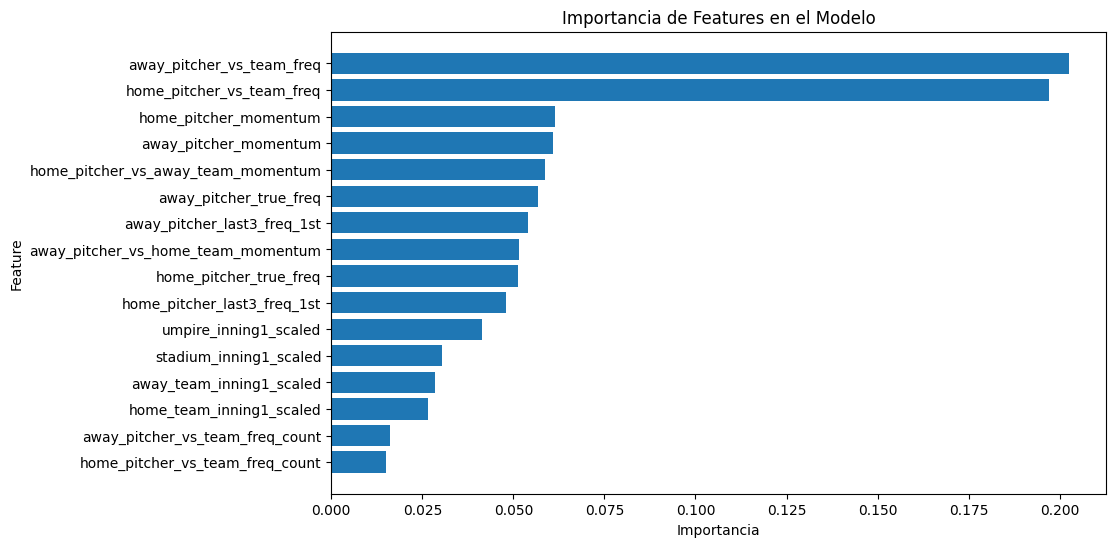

In [7]:
import matplotlib.pyplot as plt

# IMPORTANCIA DE FEATURES
importancias = modelo.feature_importances_
features_importancia = pd.DataFrame({
    'feature': features,
    'importance': importancias
}).sort_values(by='importance', ascending=False)

print("\n🔥 Importancia de cada feature en el modelo:\n")
print(features_importancia)

# También mostrar en gráfica de barras
plt.figure(figsize=(10,6))
plt.barh(features_importancia['feature'], features_importancia['importance'])
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Importancia de Features en el Modelo")
plt.gca().invert_yaxis()
plt.show()